In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import plotly.express as px
import time
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")


# Clean Data

In [ ]:
def wrangle(file_path):
  df = pd.read_csv(file_path)

  # Remove Columns
  df.drop(columns=["meantemp", "wind_speed", "meanpressure"], inplace=True)

  # Set Index to be "date"
  df = df.set_index("date")

  y = df["humidity"] # Return pd Series


  return y

In [ ]:
y = wrangle("/content/drive/MyDrive/Machine Learning/Machine Learning Projects/Time Series Data/Data/DailyDelhiClimateTrain.csv")
y.head()

,humidity
date,
2013-01-01,84.500000
2013-01-02,92.000000
2013-01-03,87.000000
2013-01-04,71.333333
2013-01-05,86.833333


# EDA

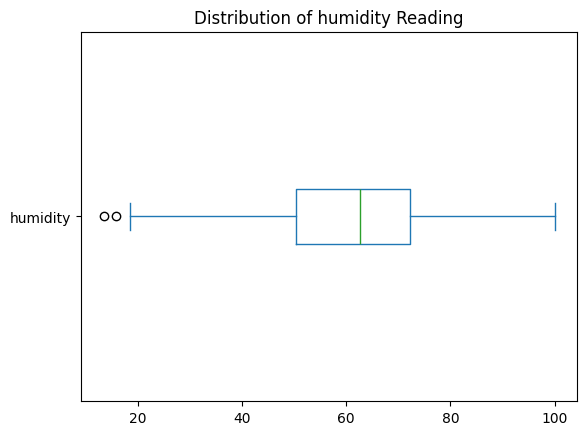

In [ ]:
y.plot(
    kind="box",
    vert=False,
    title="Distribution of humidity Reading",
);

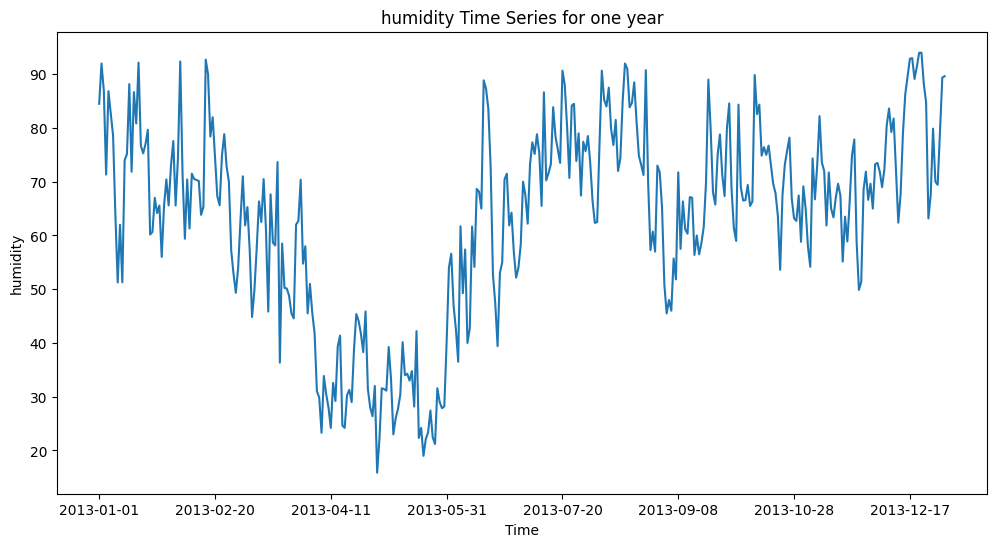

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

y[:"2014-01-01"].plot(title="humidity Time Series for one year", xlabel=("Time"), ylabel=("humidity"), ax = ax);

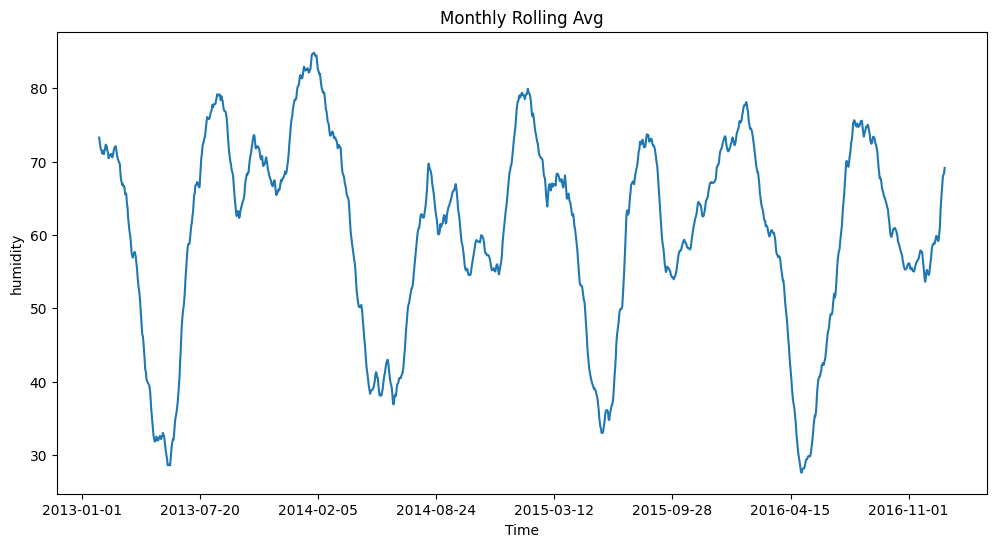

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
y.rolling(30).mean().plot(title="Monthly Rolling Avg", xlabel=("Time"), ylabel=("humidity"), ax = ax);

## ACF and PACF

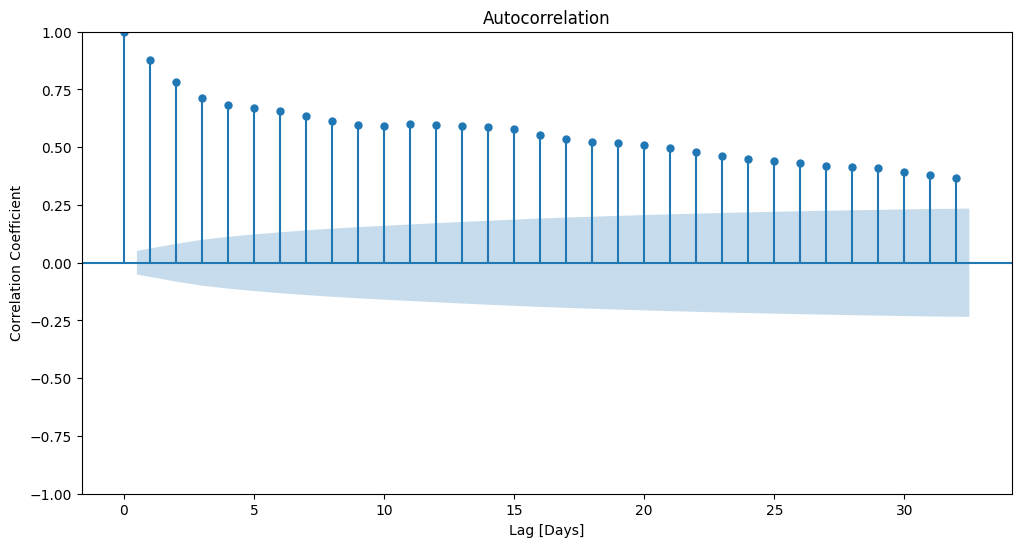

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

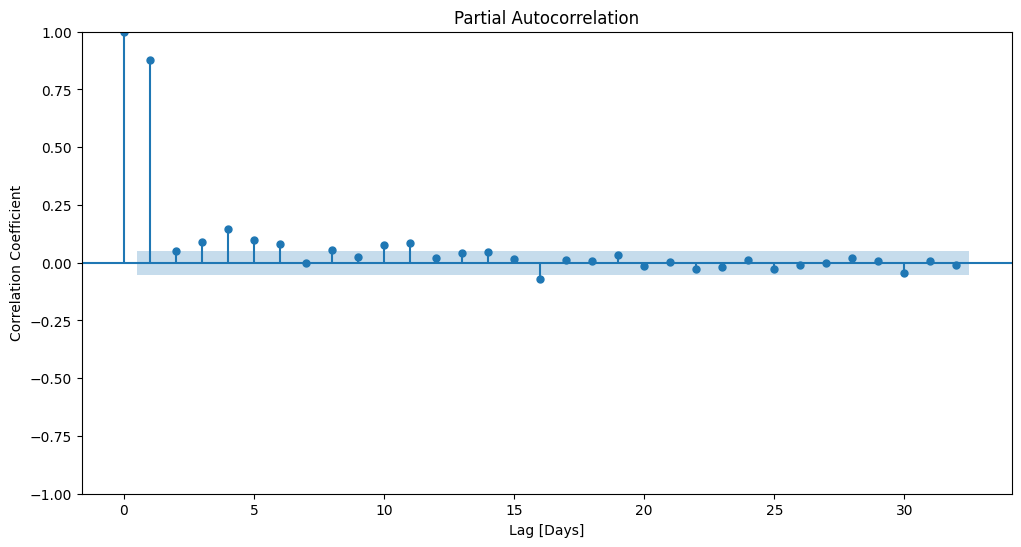

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

## Split

In [ ]:
cutoff_test = int(len(y) * 0.95)

y_train = y[:cutoff_test]
y_test = y[cutoff_test:]

# AR Model

In [ ]:
model = AutoReg(y_train, lags=16).fit()

y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[16:], y_pred)
print("Taining MAE: ", training_mae)

Taining MAE:  5.783109987935975


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Residuals

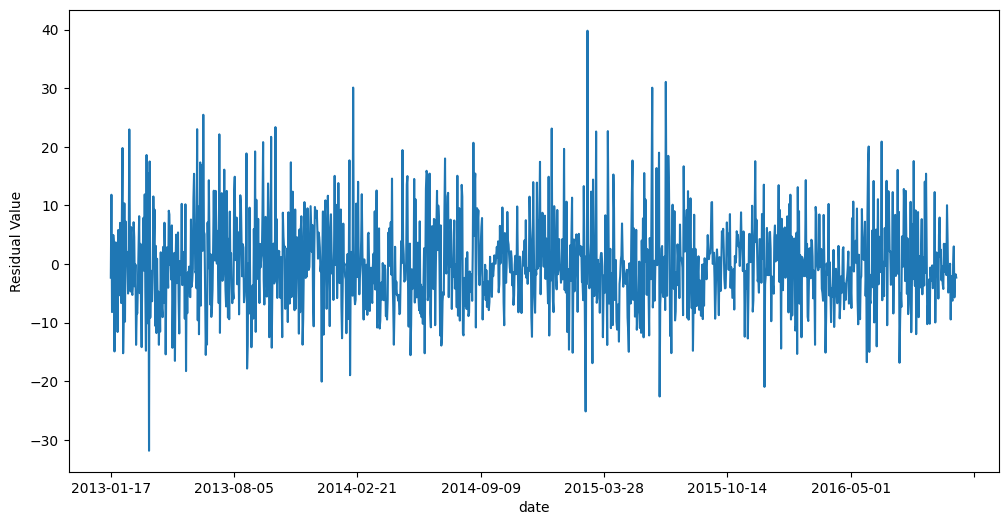

In [ ]:
y_train_resid = model.resid

fig, ax = plt.subplots(figsize=(12, 6))
y_train_resid.plot(ylabel="Residual Value" , ax=ax);

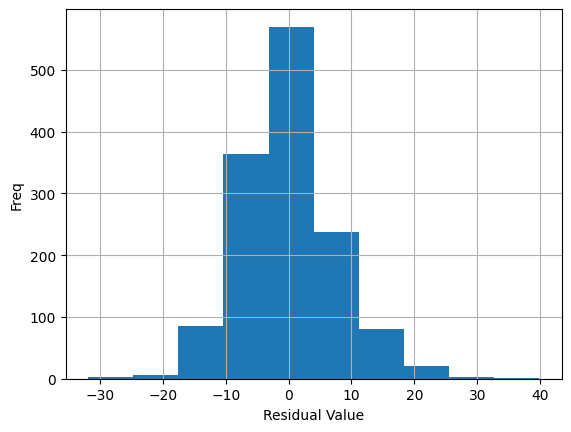

In [ ]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Freq");

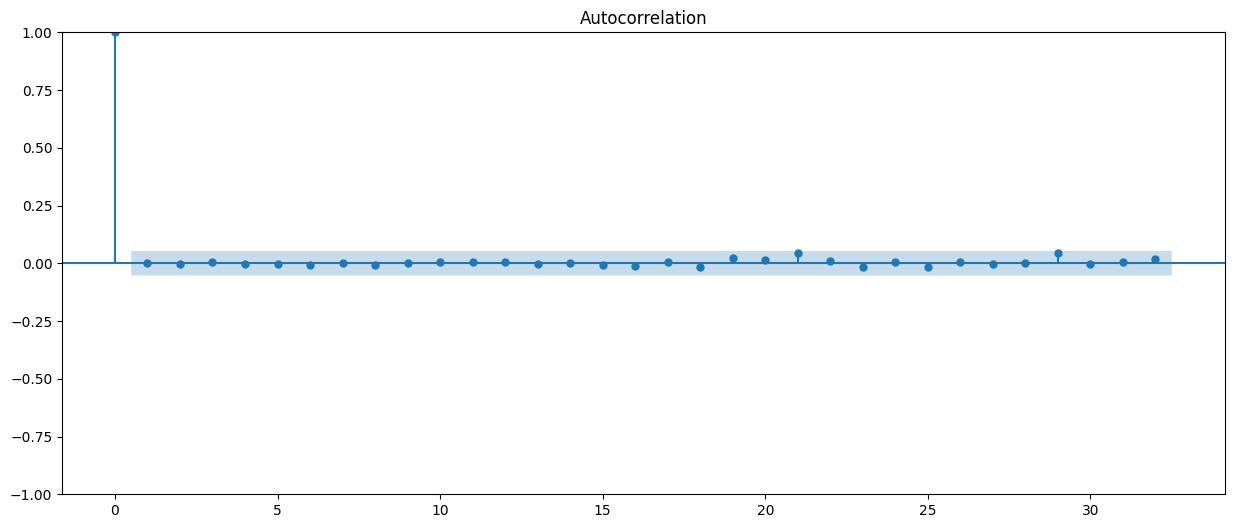

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

## Evaluate WFV

In [ ]:
y_pred_wfv = []
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags=16).fit()
    yhat = model.forecast(steps=1).iloc[0]

    y_pred_wfv.append(yhat)
    history = pd.concat([history, y_test.iloc[[i]]])

y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)

test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 5.95


In [ ]:
print(model.params)

const           3.259879
humidity.L1     0.785932
humidity.L2    -0.041386
humidity.L3    -0.021723
humidity.L4     0.051421
humidity.L5     0.035703
humidity.L6     0.081894
humidity.L7    -0.065040
humidity.L8     0.059903
humidity.L9    -0.059353
humidity.L10    0.028995
humidity.L11    0.057417
humidity.L12   -0.001090
humidity.L13    0.000994
humidity.L14    0.031714
humidity.L15    0.073526
humidity.L16   -0.072680
dtype: float64


In [ ]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_wfv": y_pred_wfv
    }
)

df_pred_test

fig = px.line(df_pred_test, labels={"value": "Humidity"})
fig.show()

# ARIMA Model

## Hyperparameter Grid Search

In [ ]:
p_params = range(0, 16, 1)
q_params = range(0, 3)

In [ ]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.35 seconds.
Trained ARIMA (0, 0, 1) in 0.31 seconds.
Trained ARIMA (0, 0, 2) in 0.57 seconds.
Trained ARIMA (1, 0, 0) in 0.17 seconds.
Trained ARIMA (1, 0, 1) in 0.36 seconds.
Trained ARIMA (1, 0, 2) in 0.61 seconds.
Trained ARIMA (2, 0, 0) in 0.48 seconds.
Trained ARIMA (2, 0, 1) in 1.23 seconds.
Trained ARIMA (2, 0, 2) in 1.89 seconds.
Trained ARIMA (3, 0, 0) in 0.33 seconds.
Trained ARIMA (3, 0, 1) in 1.67 seconds.
Trained ARIMA (3, 0, 2) in 4.18 seconds.
Trained ARIMA (4, 0, 0) in 0.55 seconds.
Trained ARIMA (4, 0, 1) in 1.73 seconds.
Trained ARIMA (4, 0, 2) in 3.75 seconds.
Trained ARIMA (5, 0, 0) in 1.05 seconds.
Trained ARIMA (5, 0, 1) in 2.38 seconds.
Trained ARIMA (5, 0, 2) in 5.34 seconds.
Trained ARIMA (6, 0, 0) in 1.13 seconds.
Trained ARIMA (6, 0, 1) in 2.43 seconds.
Trained ARIMA (6, 0, 2) in 2.79 seconds.
Trained ARIMA (7, 0, 0) in 1.54 seconds.
Trained ARIMA (7, 0, 1) in 5.93 seconds.
Trained ARIMA (7, 0, 2) in 4.71 seconds.
Trained ARIMA (8

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,13.6148,6.0180,6.0229,5.9839,5.9326,5.9071,5.8749,5.8750,5.8658,5.8678,5.8566,5.8546,5.8550,5.8621,5.8607,5.8614
1,9.2171,6.0249,6.0238,5.8675,5.8626,5.8617,5.8763,5.8726,5.8707,5.8662,5.8585,5.8588,5.8593,5.8665,5.8608,5.8610
2,7.7229,5.9572,5.8711,5.8939,5.8601,5.8573,5.8617,5.8621,5.8612,5.8728,5.8588,5.8612,5.8597,5.8600,5.8523,5.8633


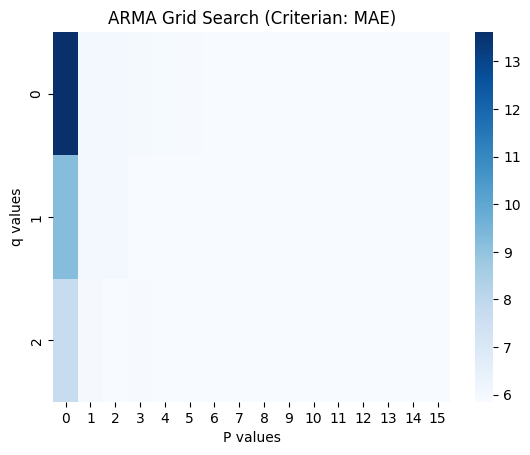

In [ ]:
sns.heatmap(mae_df, cmap="Blues")

plt.xlabel("P values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criterian: MAE)");

## Evaluate WFV

In [ ]:
y_pred_wfv = []
history = y_train.copy()

for i in range(len(y_test)):
    model = ARIMA(history, order=(4, 0 , 2)).fit()
    yhat = model.forecast(steps=1).iloc[0]

    y_pred_wfv.append(yhat)
    history = pd.concat([history, y_test.iloc[[i]]])

y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)

test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 5.75


In [ ]:
df_predictions = pd.DataFrame(
    {
        "y-test": y_test,
        "y_pred": y_pred_wfv
    }
)
fig = px.line(df_predictions)
fig.show()

**The ARIMA(4,0,2) model demonstrates improved performance compared to the AR model with 16 lags. While the AR(16) baseline successfully captured short-term dependencies, it exhibited noticeable lag and reduced responsiveness during sharp changes in humidity. By incorporating moving average terms, ARIMA(4,0,2) is better able to model residual autocorrelation and short-term shocks, resulting in smoother and more accurate walk-forward forecasts. Visual inspection and error metrics confirm that ARIMA(4,0,2) tracks peaks and troughs more closely, making it a more suitable model for this time-series forecasting task.**